In [ ]:
# Alexander Nechyporenko
# 15ann2
# 20021759

In [ ]:
# installing the relevant package along with importing all necessary components
!pip install shap

import pandas as pd
import numpy as np
import xgboost
import shap

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_log_error
from sklearn.decomposition import TruncatedSVD

import seaborn
import matplotlib.pyplot as plt

import io
from google.colab import files

In [ ]:
# upload csv file name insurance into pandas dataframe format
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['insurance.csv']))
insurance_data = pd.DataFrame(df)

Saving insurance.csv to insurance.csv


In [ ]:
# Convert categorical data into numerical matrix format
df_train = pd.get_dummies(insurance_data)

# drop charges which is the label column, keep the rest which will be used for model training in a supervised format.
# label data is the target column, which is the charge amount for insurance
feature_data = df_train.drop(columns=['charges'])
label_data = df_train[['charges']]

# split data into train and test sets, where train is 75 percent of the orignal data and test is 25 percent
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.25, random_state=42)

In [ ]:
svd = TruncatedSVD(algorithm='arpack', n_components=5)
svd_train = pd.DataFrame(svd.fit_transform(X_train))
svd_test = pd.DataFrame(svd.fit_transform(X_test))

In [ ]:
# Decomposing the data with TSNE, onto 2 dimensions. This is a feature reduction technique that is meant to maintain information while
# making the model more scalable due to the dimensional reduction of the matrix of the feature set
tsne_decomposition = TSNE(n_components=2, verbose=3, perplexity=55, n_iter=700)
tsne_train = tsne_decomposition.fit_transform(X_train)

tsne_decomposition = TSNE(n_components=2, verbose=3, perplexity=55, n_iter=700)
tsne_test = tsne_decomposition.fit_transform(X_test)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 1003 samples in 0.002s...
[t-SNE] Computed neighbors for 1003 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1003
[t-SNE] Computed conditional probabilities for sample 1003 / 1003
[t-SNE] Mean sigma: 2.782797
[t-SNE] Computed conditional probabilities in 0.182s
[t-SNE] Iteration 50: error = 56.8245354, gradient norm = 0.1972563 (50 iterations in 1.876s)
[t-SNE] Iteration 100: error = 55.0865173, gradient norm = 0.1614215 (50 iterations in 1.745s)
[t-SNE] Iteration 150: error = 54.9872894, gradient norm = 0.1504233 (50 iterations in 1.400s)
[t-SNE] Iteration 200: error = 54.9710922, gradient norm = 0.1548899 (50 iterations in 1.603s)
[t-SNE] Iteration 250: error = 55.0129776, gradient norm = 0.1623260 (50 iterations in 2.202s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.012978
[t-SNE] Iteration 300: error = 0.4622930, gradient norm = 0.0004322 (50 iterations in 1.731s

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Iteration 50: error = 52.4787254, gradient norm = 0.5446314 (50 iterations in 0.447s)
[t-SNE] Iteration 100: error = 53.6369095, gradient norm = 0.5363263 (50 iterations in 0.527s)
[t-SNE] Iteration 150: error = 52.7561493, gradient norm = 0.5405478 (50 iterations in 0.614s)
[t-SNE] Iteration 200: error = 53.5214577, gradient norm = 0.5300533 (50 iterations in 1.384s)
[t-SNE] Iteration 250: error = 54.2546997, gradient norm = 0.4988138 (50 iterations in 0.866s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.254700
[t-SNE] Iteration 300: error = 0.2729051, gradient norm = 0.0013611 (50 iterations in 0.332s)
[t-SNE] Iteration 350: error = 0.2603279, gradient norm = 0.0004260 (50 iterations in 0.327s)
[t-SNE] Iteration 400: error = 0.2206797, gradient norm = 0.0003323 (50 iterations in 0.375s)
[t-SNE] Iteration 450: error = 0.2208186, gradient norm = 0.0000900 (50 iterations in 0.557s)
[t-SNE] Iteration 500: error = 0.2208077, gradient norm = 0.0000826 (50 

In [ ]:
# classify charge brackets of insurance for illustration purposes for TSNE components
def classification(charges):
  if charges <= 15000:
    return "Bracket 1"
  elif charges <=27000:
    return "Bracket 2"
  elif charges <=50000:
    return "Bracket 3"
  else:
    return "Bracket 4"

y_brackets = y_train['charges'].apply(classification)

Text(0, 0.5, 'Reduction 2')

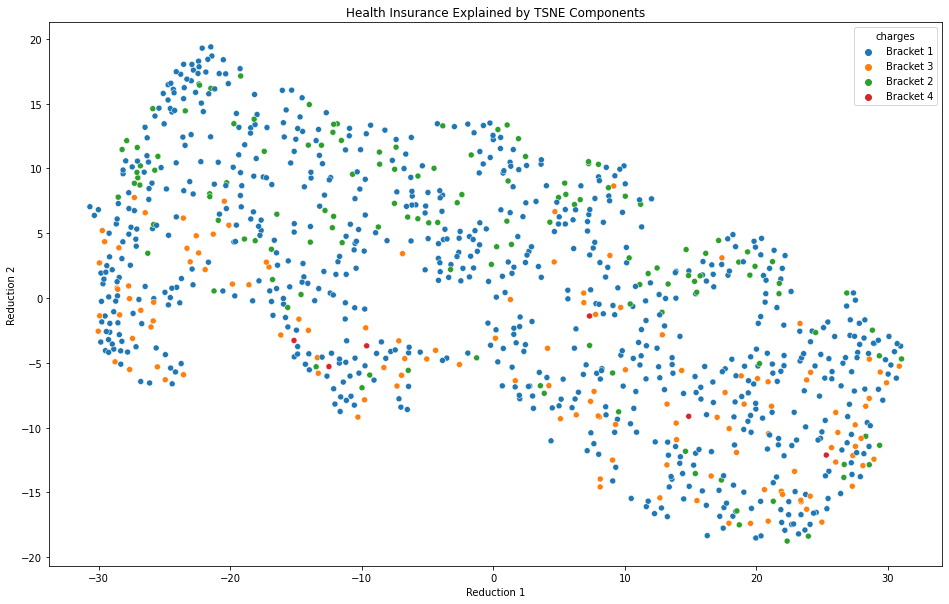

In [ ]:
# Here we illustrate the TSNE components and how they map out to the different brackets of
# the charges for medical insurance
first_comp = tsne_train[:,0]
second_comp = tsne_train[:,1]

plt.figure(figsize=(16,10))
seaborn.scatterplot(
    x=first_comp, y=second_comp,
    hue=y_brackets,
    legend="full",
)

plt.title("Health Insurance Explained by TSNE Components")
plt.xlabel("Reduction 1")
plt.ylabel("Reduction 2")

Text(0.5, 1.0, 'Correlation Between Features')

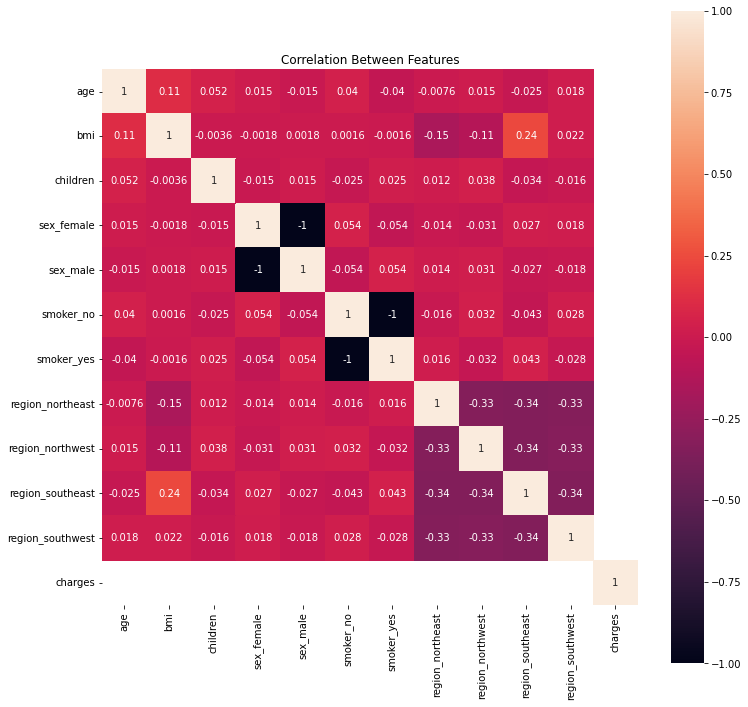

In [ ]:
# This generates a heatmap of thea feature set in order to map out the correlation between different
# features, which can give insight into the importance of the different features and how they work with other
# features.
_ , axis = plt.subplots(figsize =(12, 12)) 
seaborn.heatmap(
    X_train.corr(), 
    annot=True,
    square=True, 
    ax=axis,
    )
plt.title("Correlation Between Features")

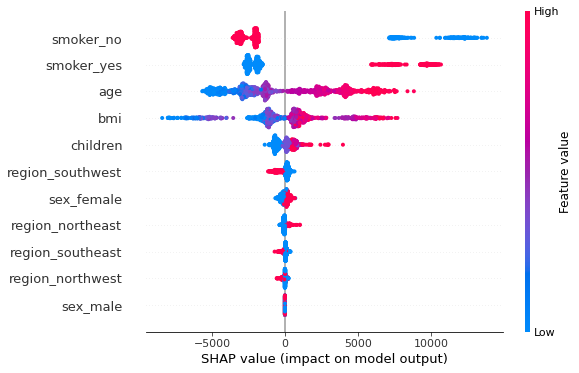

In [ ]:
# SHAP is a tool used for explaining the relevance of the different features and the effects it has
# on the output of the model. It will rank different features on the potential impact it will have on any given machine learning model.
explainer = shap.TreeExplainer(xgboost_model)
shap_valuesa = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_valuesa, X_train)
shap.summary_plot(shap_valuesa,X_train)

In [ ]:
# Here, I train the model on TSNE components and then make predictions based on that utilizing xgboost decision tree modelling.
xgboost_matrix = xgboost.DMatrix(data=tsne_train, label=y_train)
params = {
    "objective":'reg:squarederror', 
    "colsample_bytree":0.6, 
    "learning_rate":0.4, 
    "max_depth":5, 
    "alpha":10, 
    "n_boost_round":20,
    "gamma": 0.001,
    'min_child_weight': 1.5,
    'reg_alpha': 0.75,
    }
xgboost_model = xgboost.train(params=params, dtrain=xgboost_matrix)

xgboost_test = xgboost.DMatrix(data=tsne_test)
yHat = xgboost_model.predict(xgboost_test)

# this prints the mean squared error margine between predictions and label data for the test set
print("Mean squared error margine between predictions and actual label data: " + str(np.sqrt(mean_squared_error(yHat, y_test))))
print("MAE score: " + str(mean_absolute_error(yHat, y_test)))

Mean squared error margine between predictions and actual label data: 13140.09618361388
MAE score: 9498.581975874253


In [ ]:
# Here, I train the model on all features from the orginal set and then make predictions based on that utilizing xgboost decision tree modelling.
xgboost_matrix = xgboost.DMatrix(data=X_train, label=y_train)
params = {
    "objective":'reg:squarederror', 
    "colsample_bytree":0.6, 
    "learning_rate":0.4, 
    "max_depth":5, 
    "alpha":10, 
    "n_boost_round":20,
    "gamma": 0.001,
    'min_child_weight': 1.5,
    'reg_alpha': 0.75,
    }
xgboost_model = xgboost.train(params=params, dtrain=xgboost_matrix)

xgboost_test = xgboost.DMatrix(data=X_test)
yHat = xgboost_model.predict(xgboost_test)

print("Mean squared error margine between predictions and actual label data: " + str(np.sqrt(mean_squared_error(yHat, y_test))))
print("MAE score: " + str(mean_absolute_error(yHat, y_test)))

Mean squared error margine between predictions and actual label data: 4575.2002294341
MAE score: 2511.3372400572994


In [ ]:
# Here, I train the model on all features from the orginal set and then make predictions based on that utilizing xgboost decision tree modelling.
xgboost_matrix = xgboost.DMatrix(data=svd_train, label=y_train)
params = {
    "objective":'reg:squarederror', 
    "colsample_bytree":0.6, 
    "learning_rate":0.4, 
    "max_depth":5, 
    "alpha":10, 
    "n_boost_round":20,
    "gamma": 0.001,
    'min_child_weight': 1.5,
    'reg_alpha': 0.75,
    }
xgboost_model = xgboost.train(params=params, dtrain=xgboost_matrix)

xgboost_test = xgboost.DMatrix(data=svd_test)
yHat = xgboost_model.predict(xgboost_test)

print("Mean squared error margine between predictions and actual label data: " + str(np.sqrt(mean_squared_error(yHat, y_test))))
print("MAE score: " + str(mean_absolute_error(yHat, y_test)))

Mean squared error margine between predictions and actual label data: 7414.375652760128
MAE score: 5038.8632803075325


In [ ]:
# based on the SHAP and heatmap of the correlation data, we remove the following features to run another test
feature2 = feature_data.drop(['sex_male', 'region_northwest', 'region_northeast', 'region_southeast'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.25, random_state=42)

In [ ]:
# Running the same model parameters, we test based on the fewer selected feature values
xgboost_matrix = xgboost.DMatrix(data=X_train, label=y_train)
params = {
    "objective":'reg:squarederror', 
    "colsample_bytree":0.7, 
    "learning_rate":0.4, 
    "max_depth":3, 
    "alpha":.01, 
    "n_boost_round":15,
    "gamma": 0.001,
    'min_child_weight': 1.5,
    'reg_alpha': 0.75
    }
xgboost_model = xgboost.train(params=params, dtrain=xgboost_matrix)

xgboost_test = xgboost.DMatrix(data=X_test)
yHat = xgboost_model.predict(xgboost_test)

print("Mean squared error margine between predictions and actual label data: " + str(np.sqrt(mean_squared_error(yHat, y_test))))
print("MAE score: " + str(mean_absolute_error(yHat, y_test)))

Mean squared error margine between predictions and actual label data: 4656.588480774141
MAE score: 2717.071319657346


In [ ]:
# Utilizing mean square and log differencing, we find the percentage of the error margin and then find the percentage accuracy of the model predictions
def mean_square_log(predictions, label):
  err_val = pow(np.square(np.log10(predictions +1) - np.log10(label +1)).mean(), 0.5)
  return 1 - err_val

print("Accuracy attained on Test Set = ", mean_square_log(yHat, y_test['charges']))

Accuracy attained on Test Set =  0.8067366435625432
